<a href="https://colab.research.google.com/github/mohsenMahmoodzadeh/Image-Caption-classification-with-tensorflow-Keras/blob/master/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image & Caption Classification

## Import Libraries

In [6]:
import tensorflow as tf
from tensorflow.keras import *
import numpy as np
import pandas as pd
import h5py
from PIL import Image
from matplotlib import pyplot as plt
from IPython.display import clear_output
import os
import cv2
import warnings
import random

In [44]:
!pwd

/content


In [8]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [9]:

TRAIN_DATA_DIR = '/content/drive/MyDrive/dataset/train/images/'
TEST_DATA_DIR = '/content/drive/MyDrive/dataset/test/images/'
# TRAIN_DATA_DIR = './dataset/train/images/'
# TEST_DATA_DIR = './dataset/test/images'

TRAIN_DATA_SIZE = 532
TEST_DATA_SIZE = 380

NUMBER_OF_CLASSES = 19

IMG_WIDTH = 224
IMG_HEIGHT = 224

TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32

NUMBER_OF_CHANNELS = 3

LEARNING_RATE = 0.0001

EPOCHS = 10

In [2]:
label_map = {
    0 : 'aeroplane', 1 : 'bicycle', 2 : 'bird', 3 : 'boat', 
    4 : 'bus', 5 : 'car', 6 : 'cat', 7 : 'chair', 8 : 'cow',
    9 : 'diningtable', 10 : 'dog', 11 : 'horse', 12 : 'motorbike',
    13 : 'person', 14 : 'pottedplant', 15 : 'sheep', 16 : 'sofa',
    17 : 'train', 18 : 'tvmonitor'
  }

In [3]:
CATEGORIES = list(label_map.values())

In [10]:
def prepare_data(DATA_DIR, CATEGORIES, img_width, img_height):
    data = []
    path = ""
    for category in CATEGORIES:
        path = os.path.join(DATA_DIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            img = os.path.join(path, img)
            try:
                img_array = cv2.imread(img, cv2.IMREAD_UNCHANGED)
                new_array = cv2.resize(img_array, (img_width, img_height))
                data.append([new_array, class_num])
            except Exception as e:
                print(str(e))

    return data

In [11]:
training_data = prepare_data(TRAIN_DATA_DIR, CATEGORIES, 
                                   IMG_WIDTH, IMG_HEIGHT)

In [12]:
test_data = prepare_data(TEST_DATA_DIR, CATEGORIES, 
                                   IMG_WIDTH, IMG_HEIGHT)

In [13]:
random.shuffle(training_data)
random.shuffle(test_data)

In [14]:
val_data_size = int(len(test_data) * 0.3)
val_data = test_data[:val_data_size]
test_data = test_data[val_data_size:]

In [16]:
print("the count of test samples: " + str(len(test_data)))
print("the count of validation samples: " + str(len(val_data)))

the count of test samples: 266
the count of validation samples: 114


In [17]:
X_train = []
y_train = []
for features, classes in training_data:
    X_train.append(features)
    y_train.append(classes)

X_train = np.array(X_train).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 
                                    NUMBER_OF_CHANNELS)
y_train = np.array(y_train)
y_train = tf.keras.utils.to_categorical(y_train)

In [18]:
X_val = []
y_val = []
for features, classes in val_data:
    X_val.append(features)
    y_val.append(classes)

X_val = np.array(X_val).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 
                                    NUMBER_OF_CHANNELS)
y_val = np.array(y_val)
y_val = tf.keras.utils.to_categorical(y_val)

In [19]:
X_test = []
y_test = []
for features, classes in test_data:
    X_test.append(features)
    y_test.append(classes)

X_test = np.array(X_test).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 
                                  NUMBER_OF_CHANNELS)
y_test = np.array(y_test)

y_test = tf.keras.utils.to_categorical(y_test)

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

test_generator = ImageDataGenerator(rescale=1./255)

train_generator_no_aug = ImageDataGenerator(rescale=1./255)

In [21]:
train_flow = train_generator.flow(
        X_train, 
        y_train,
      )

# train_flow = train_generator.flow_from_directory(
#         TRAIN_DATA_DIR,
#         target_size=(IMG_HEIGHT, IMG_WIDTH),
#         batch_size=TRAIN_BATCH_SIZE,
#         class_mode='categorical'
#       )

In [24]:
test_flow = test_generator.flow(
        X_val,
        y_val,
      ) 

# test_flow = test_generator.flow_from_directory(
#         TEST_DATA_DIR,
#         target_size=(IMG_HEIGHT, IMG_WIDTH),
#         batch_size=TEST_BATCH_SIZE,
#         class_mode='categorical'
#       ) 

In [30]:
test_gen = test_generator.flow(
        X_test,
        y_test,
      ) 

In [23]:
model = tf.keras.models.load_model('/content/drive/MyDrive/DenseNet169.h5')

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_flow,
    # TRAIN_DATA_SIZE // TRAIN_BATCH_SIZE,
    epochs= 10,
    validation_data= test_flow,
    # validation_steps= TEST_DATA_SIZE // TEST_BATCH_SIZE
    )

Epoch 1/10
17/17 [==============================] - 573s 33s/step - loss: 0.1300 - accuracy: 0.9699 - val_loss: 1.5094 - val_accuracy: 0.6053
Epoch 2/10
17/17 [==============================] - 551s 33s/step - loss: 0.0922 - accuracy: 0.9868 - val_loss: 1.4534 - val_accuracy: 0.5965
Epoch 3/10
17/17 [==============================] - 552s 32s/step - loss: 0.0695 - accuracy: 0.9868 - val_loss: 1.5092 - val_accuracy: 0.6491
Epoch 4/10
17/17 [==============================] - 555s 33s/step - loss: 0.0704 - accuracy: 0.9906 - val_loss: 1.6679 - val_accuracy: 0.5965
Epoch 5/10
17/17 [==============================] - 558s 33s/step - loss: 0.0435 - accuracy: 0.9925 - val_loss: 1.7225 - val_accuracy: 0.5965
Epoch 6/10
17/17 [==============================] - 554s 33s/step - loss: 0.0314 - accuracy: 0.9962 - val_loss: 1.8190 - val_accuracy: 0.5526
Epoch 7/10
17/17 [==============================] - 547s 32s/step - loss: 0.0354 - accuracy: 0.9944 - val_loss: 1.6301 - val_accuracy: 0.5965
Epoch 

Text(0.5, 1.0, 'Training and validation loss')

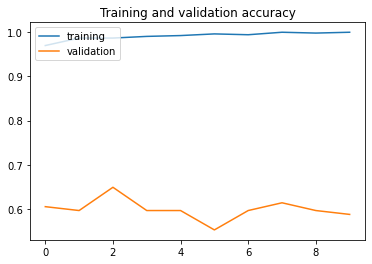

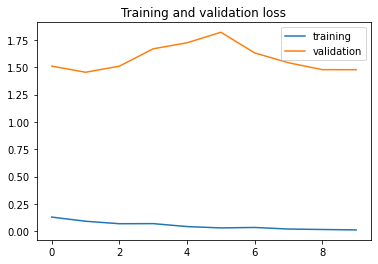

In [28]:
 acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

In [32]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

print()

print('Classification Report')
print(classification_report(y_test, 
                            y_pred, 
                            target_names=CATEGORIES))

Confusion Matrix


ValueError: ignored

In [31]:
loss_and_metrics = model.evaluate(test_gen, verbose=2)
print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

9/9 - 47s - loss: 1.7054 - accuracy: 0.6090
Test Loss 1.7054133415222168
Test Accuracy 0.6090225577354431
